In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from anndata import AnnData
sc.settings.verbosity = 3
from scipy.sparse import csc_matrix
from anndata import AnnData
from scipy.sparse import load_npz
import spatialSNV as ss

from tqdm import tqdm
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
# pip install gseapy
import gseapy as gp


def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
vector(False)

from scipy.sparse import save_npz, load_npz
def get_min_distance(adata):
    locations = adata.obsm['spatial'].copy()
    distances = np.linalg.norm(locations[:, np.newaxis] - locations, axis=2)
    np.fill_diagonal(distances, np.inf)
    min_distances = np.min(distances, axis=1)
    average_min_distance = np.mean(min_distances)
    return average_min_distance

def _normalize_data(X, counts, after= None):
    from sklearn.utils.sparsefuncs import inplace_row_scale
    X = X.copy()
    after = np.median(counts_greater_than_zero, axis=0) if after is None else after
    counts += counts == 0
    counts = counts / after
    inplace_row_scale(X, 1 / counts)
    return X

root_path = "/storage/liuyi/00.SNP_project/code/gigascience_update"

/home/liuyi/miniconda3/envs/spatialsnv/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/liuyi/miniconda3/envs/spatialsnv/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/liuyi/miniconda3/envs/spatialsnv/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/liuyi/miniconda3/envs/spatialsnv/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/liuyi/miniconda3/envs/spatialsnv/lib/python3.10/site-packages/anndata/utils.py:429: 

In [2]:
sample = 'CRC-P59-T_1'

In [3]:
rna = sc.read_h5ad(f'{root_path}/rna_adata/{sample}.rna.h5ad')
snv = sc.read_h5ad(f'{root_path}/snv_adata/{sample}.snv.h5ad')

In [4]:
snv_df = snv.to_df().T
window_size = 100000
snv_df['chrom'] = snv_df.index.map(lambda x: x.split('_')[0])
snv_df['num'] = snv_df.index.map(lambda x: str(int(x.split('_')[1].split(':')[0])//window_size))
snv_df['windows'] = snv_df['chrom'] +'@'+ snv_df['num']
del snv_df['chrom']
del snv_df['num']
snv_df = snv_df.groupby('windows').sum().T
snv_gene_adata = AnnData(snv_df)
snv_gene_adata.X = csc_matrix(snv_gene_adata.X)
snv_gene_adata.obsm['spatial'] = snv.obsm['spatial']

In [5]:
snv_gene_adata.obs['cluster'] = rna.obs['cluster']
snv_gene_adata = snv_gene_adata[snv_gene_adata.obs['cluster']!='Normal'].copy()
sc.pp.filter_genes(snv_gene_adata,min_cells=1)

In [6]:
radius = get_min_distance(snv_gene_adata)
ss_con = ss.build_connect(snv_gene_adata, radius = 5 * (radius), include_self=False, norm=True, scaling=False, rank2=False,
                          rank_cutoff = 50, n_neighbors = 30, use_raw=False, decay='Gaussian')

/home/liuyi/miniconda3/envs/spatialsnv/lib/python3.10/site-packages/spatialSNV.py:86: RuntimeWarning: divide by zero encountered in divide
  scalers = 1 / scalers


Step1: cell-cell connectivity calculation finished, Fri May  9 10:54:22 2025
Step2: ranking SNV expression values finished, Fri May  9 10:54:33 2025


/home/liuyi/miniconda3/envs/spatialsnv/lib/python3.10/site-packages/spatialSNV.py:150: RuntimeWarning: divide by zero encountered in divide
  scaler_mode = 1/mode


Step3: cell-SNV connectivity calculation finished, Fri May  9 10:54:35 2025
Step5: SNV-SNV connectivity calculation finished, Fri May  9 10:54:37 2025


In [7]:
snv_gene_adata,ac = ss.build_sg(snv_gene_adata, con = ss_con,resolution = 10, syn = False)

In [8]:
# ac.write('crct1.ac.h5ad')
# snv_gene_adata.write('crct1.snv_gene_adata.h5ad')
# save_npz(‘ss_con_matrix.npz’, ss_con)

In [9]:
ac = sc.read_h5ad(f'{root_path}/otherdata_for_figure/Figure5/crct1.ac.h5ad')
snv_gene_adata = sc.read_h5ad(f'{root_path}/otherdata_for_figure/Figure5/crct1.snv_gene_adata.h5ad')
ss_con = load_npz(f'{root_path}/otherdata_for_figure/Figure5/ss_con_matrix.npz')

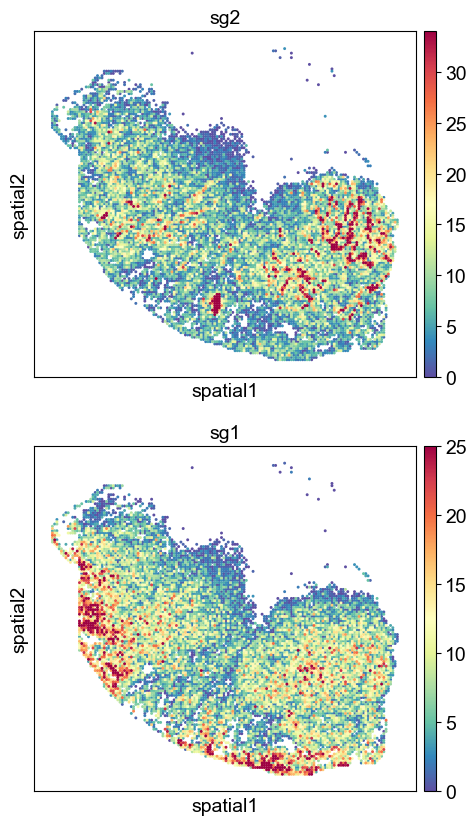

In [10]:
fig,axs = plt.subplots(2,1,figsize = (10,10))
sc.pl.spatial(ac,basis = 'spatial',color = ['sg2'],spot_size = 130,cmap = 'Spectral_r',vmax = 'p98',show = False,ax = axs[0])
sc.pl.spatial(ac,basis = 'spatial',color = ['sg1'],spot_size = 130,cmap = 'Spectral_r',vmax = 'p98' ,show = False,ax= axs[1])
fig.show()

In [11]:
tmp_df = snv.var.copy()
tmp_df['chrom'] = tmp_df.index.map(lambda x: x.split('_')[0])
tmp_df['num'] = tmp_df.index.map(lambda x: str(int(x.split('_')[1].split(':')[0])//window_size))
snv.var['windows'] = tmp_df['chrom'] +'@'+ tmp_df['num']

computing score 'TAM'
    finished: added
    'TAM', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)


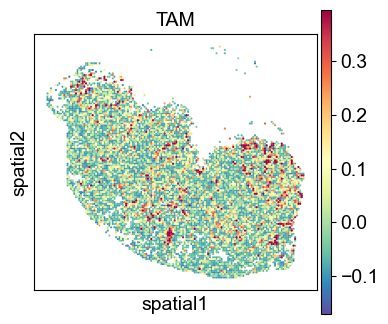

In [12]:
mac = ['CD68','CD14','MMP2','MMP9','VTCN1','CD163','MRC1']
sc.tl.score_genes(rna,mac,score_name='TAM')
sc.pl.spatial(rna[rna.obs['cluster'] != 'Normal'],basis = 'spatial',color = ['TAM'],spot_size = 130,vmax = 'p98',cmap = 'Spectral_r')

In [13]:
procon = ss.mul_rank_weight(ss_con, rank_cutoff=50, ret='value',transpose=False, include_self=False, nthreads=20)
procon = ss.weight_norm(procon, alpha=1)

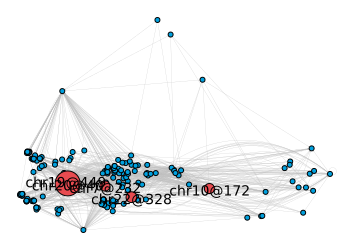

In [14]:
inlist = snv_gene_adata[:,snv_gene_adata.var['snv_group'] == 2].var_names
indices = [np.where(snv_gene_adata.var_names == gene)[0][0] for gene in inlist if gene in snv_gene_adata.var_names]
sub_con = procon[indices, :][:, indices]
g = ss.create_graph(sub_con, directed=True)
g.vs['name'] = inlist
visual_style = {}
visual_style["bbox"] = (300, 300) 
visual_style["margin"] = 20
visual_style["edge_color"] = "gray"
import igraph as ig
topn = 5
degrees = g.degree()
n = len(g.vs)
top_indices = sorted(range(n), key=lambda i: degrees[i], reverse=True)[:topn]
top_degrees = [degrees[i] for i in top_indices]
max_degree_indices = sorted(range(len(degrees)), key=lambda i: degrees[i], reverse=True)[:topn]
labels = ["" for _ in range(len(g.vs))]
for idx in max_degree_indices:
    labels[idx] = g.vs[idx]["name"]
    
min_top_degree, max_top_degree = min(top_degrees), max(top_degrees)
node_sizes = [5] * n 
for idx in top_indices:
    if max_top_degree > min_top_degree: 
        size = ((degrees[idx] - min_top_degree) / (max_top_degree - min_top_degree) * 15) + 10  
    else:
        size = 25
    node_sizes[idx] = max(size, 5)
    
layout = g.layout("mds")   #"grid"  "graphopt" "davidson_harel"  "drl" "mds" "kk"
visual_style = {}
visual_style["bbox"] = (350, 250)
visual_style["edge_color"] = "gray"
visual_style['edge_arrow_size'] = 0.1  
ig.plot(g, layout=layout,
        vertex_size=node_sizes,edge_width = 0.2,
        vertex_color=['#E84B50' if idx in top_indices else '#00A1DF' for idx in range(n)],
        vertex_label=labels,
        **visual_style)#target='./MainFigure/sg2.pdf')

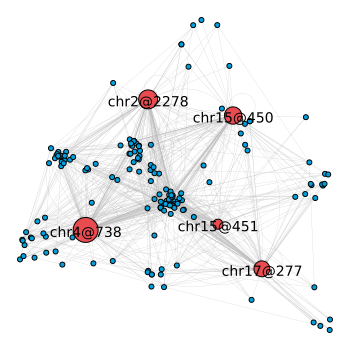

In [15]:
inlist = snv_gene_adata[:,snv_gene_adata.var['snv_group'] == 1].var_names
indices = [np.where(snv_gene_adata.var_names == gene)[0][0] for gene in inlist if gene in snv_gene_adata.var_names]
sub_con = procon[indices, :][:, indices]
g = ss.create_graph(sub_con, directed=True)
g.vs['name'] = inlist
visual_style = {}
visual_style["bbox"] = (300, 300) 
visual_style["margin"] = 20
visual_style["edge_color"] = "gray"
import igraph as ig
topn = 5
degrees = g.degree()
n = len(g.vs)
top_indices = sorted(range(n), key=lambda i: degrees[i], reverse=True)[:topn]
top_degrees = [degrees[i] for i in top_indices]
max_degree_indices = sorted(range(len(degrees)), key=lambda i: degrees[i], reverse=True)[:topn]
labels = ["" for _ in range(len(g.vs))]
for idx in max_degree_indices:
    labels[idx] = g.vs[idx]["name"]
    
min_top_degree, max_top_degree = min(top_degrees), max(top_degrees)
node_sizes = [5] * n 
for idx in top_indices:
    if max_top_degree > min_top_degree: 
        size = ((degrees[idx] - min_top_degree) / (max_top_degree - min_top_degree) * 15) + 10  
    else:
        size = 25
    node_sizes[idx] = max(size, 5)
    
layout = g.layout("mds")   #"grid"  "graphopt" "davidson_harel"  "drl" "mds" "kk"
visual_style = {}
visual_style["bbox"] = (350, 350)
visual_style["edge_color"] = "gray"
visual_style['edge_arrow_size'] = 0.1  
ig.plot(g, layout=layout,
        vertex_size=node_sizes,edge_width = 0.2,
        vertex_color=['#E84B50' if idx in top_indices else '#00A1DF' for idx in range(n)],
        vertex_label=labels,
        **visual_style)#target='./MainFigure/sg1.pdf')

In [16]:
inlist = snv_gene_adata[:,snv_gene_adata.var['snv_group'] == 2].var_names
module_snv = snv[:,snv.var['windows'].isin(inlist)]
module_snv = module_snv[:,module_snv.var['Func_L0']!='Intergenic']
module_snv = module_snv[:,~module_snv.var['gene_name'].apply(lambda x :  ';' in x)].copy()
geneList = module_snv.var['gene_name'].value_counts().to_frame()

In [17]:
norm_snv_gene_adata = snv_gene_adata.copy()
norm_snv_gene_adata.obs['UMI_counts'] = rna.obs['total_counts']
umi_per_cell = np.ravel(norm_snv_gene_adata.obs['UMI_counts'])
norm_snv_gene_adata.X = np.log1p(_normalize_data(norm_snv_gene_adata.X,umi_per_cell,after = 1e4))

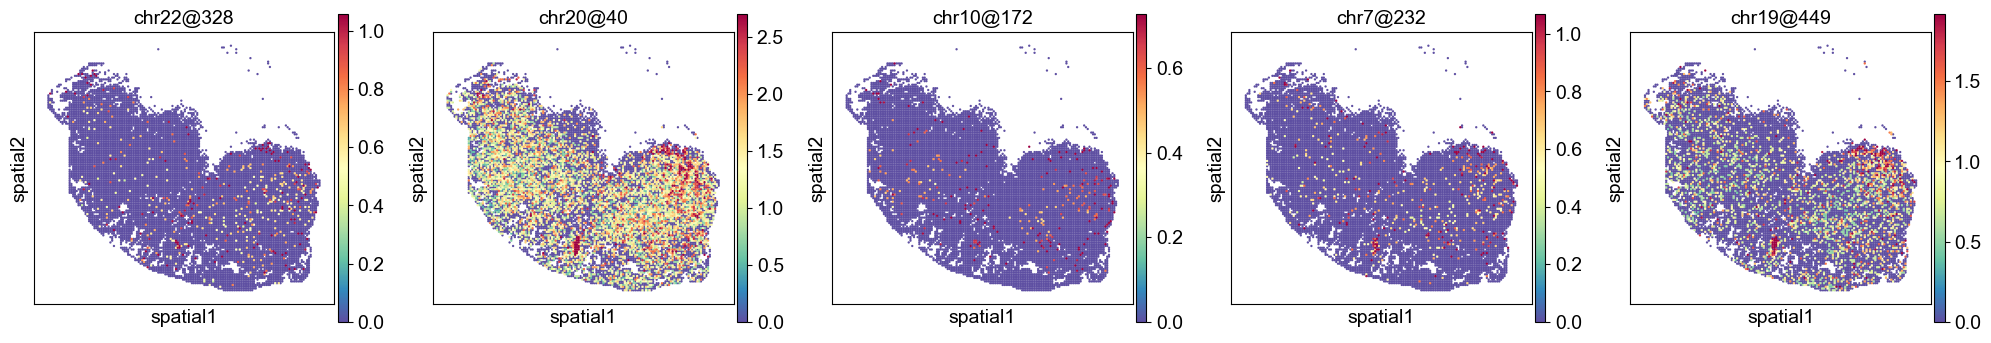

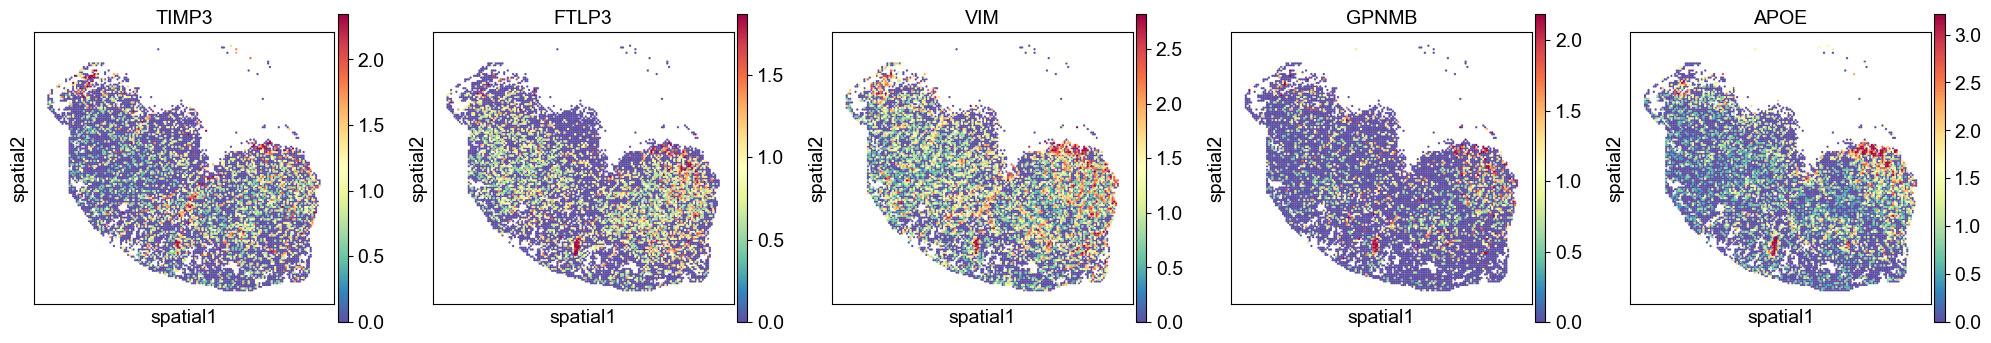

In [18]:
sc.pl.spatial(norm_snv_gene_adata,color = ['chr22@328','chr20@40','chr10@172','chr7@232','chr19@449',],spot_size = 130,vmax = 'p99',cmap = 'Spectral_r',ncols = 5)
sc.pl.spatial(rna[rna.obs['cluster'] != 'Normal'],color = ['TIMP3','FTLP3','VIM',"GPNMB",'APOE'],spot_size = 130,vmax = 'p99.5',cmap = 'Spectral_r',ncols = 5)

In [19]:
inlist = snv_gene_adata[:,snv_gene_adata.var['snv_group'] == 2].var_names
module_snv = snv[:,snv.var['windows'].isin(inlist)]
module_snv = module_snv[:,module_snv.var['Func_L0']!='Intergenic']
module_snv = module_snv[:,~module_snv.var['gene_name'].apply(lambda x :  ';' in x)].copy()
geneList = module_snv.var['gene_name'].value_counts().to_frame()
geneList.index = [str(i) for i in geneList.index]

In [20]:
import gseapy as gp
pre_res = gp.prerank(rnk= geneList,gene_sets= f"{root_path}/otherdata_for_figure/Figure5/h.all.v2023.1.Hs.symbols.gmt",threads=1,min_size=5,max_size=1000,permutation_num=1000, outdir=None, seed=6,verbose=True,)

2025-05-09 10:55:29,711 [WARNING] Duplicated values found in preranked stats: 92.64% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-05-09 10:55:29,713 [INFO] Parsing data files for GSEA.............................
2025-05-09 10:55:29,719 [INFO] 0038 gene_sets have been filtered out when max_size=1000 and min_size=5
2025-05-09 10:55:29,720 [INFO] 0012 gene_sets used for further statistical testing.....
2025-05-09 10:55:29,721 [INFO] Start to run GSEA...Might take a while..................
2025-05-09 10:55:29,757 [INFO] Congratulations. GSEApy runs successfully................



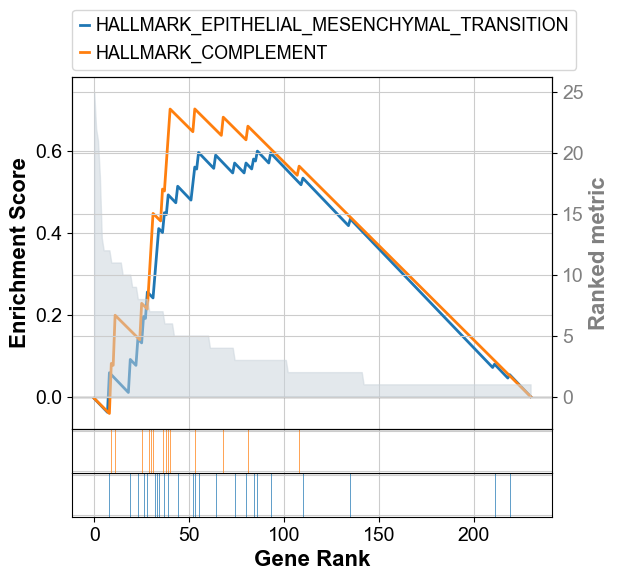

In [21]:
term = ["HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION",'HALLMARK_COMPLEMENT']
axs = pre_res.plot(terms= term, show_ranking=True)
plt.show()